# Product A/B Test - Ramon Peralta Martinez
----------

A company builds state of the art Natural Language Processing and Machine Learning tools that empower human customer service representatives to drastically increase their efficiency. The company is constantly improving upon these tools, and running experiments to ensure that changes to the machine learning models lead to increases in agent efficieny.

One of company's ML features is "auto-response", where the system suggests the next message a representative should send. The representative can opt to use the suggested message, or type out their own. The more often the representative uses the suggested message the more successful we consider the feature to be. The company tracked  a metric called `augmentation_rate`, which is the percentage of representative sent messages that came from the auto-response system.

Goals
1) Summarize the dataset (N, dates, group balance).
2) Assess experimental design (randomization unit, exposure, potential biases).
3) Estimate the treatment effect on `augmentation_rate` with uncertainty (95% CI via bootstrap or robust regression).


# Dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('/Users/ramon/Proyectos Data Science/A:B Test/data/data.csv')
df

,start_time,rep_id,rep_sent_msgs,augmented_msgs,treatment
0,2018-10-15 04:35:36,1160001,12,1,False
1,2018-10-15 04:34:33,4140001,8,3,False
2,2018-10-15 04:24:53,4450001,13,2,False
3,2018-10-15 04:33:34,4140001,9,1,False
4,2018-10-15 04:40:02,3320001,5,5,False
...,...,...,...,...,...
69109,2018-11-20 06:31:56,3370001,8,2,True
69110,2018-11-20 19:12:16,510001,10,1,False
69111,2018-11-20 19:17:30,1290001,27,8,False
69112,2018-11-20 19:19:00,670001,2,2,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69114 entries, 0 to 69113
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   start_time      69114 non-null  object
 1   rep_id          69114 non-null  int64 
 2   rep_sent_msgs   69114 non-null  int64 
 3   augmented_msgs  69114 non-null  int64 
 4   treatment       69114 non-null  bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 2.2+ MB


## Defining Column Names:
1. `start_time`: Timestamp indicating when the representative’s session started.
2. `rep_id `: Unique identifier of the human customer service representative.
3. `rep_sent_msgs`: Total number of messages sent by the representative during the session. Includes both manual and auto-response messages.
4. `augmented_msgs`: Number of messages sent by the representative that were selected from the auto-response suggestions.
5. `treatment`: Boolean flag indicating whether the representative was exposed to the new model (True) or remained in the control group with the baseline model (False).

# 1) Dataset Exploration:

In [4]:
df.isnull().sum()

start_time        0
rep_id            0
rep_sent_msgs     0
augmented_msgs    0
treatment         0
dtype: int64

We have no null data.

In [5]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69114 entries, 0 to 69113
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_time      69114 non-null  datetime64[ns]
 1   rep_id          69114 non-null  int64         
 2   rep_sent_msgs   69114 non-null  int64         
 3   augmented_msgs  69114 non-null  int64         
 4   treatment       69114 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 2.2 MB


In [7]:
df['treatment'].value_counts()

treatment
False    49371
True     19743
Name: count, dtype: int64

We are dealing with an imbalanced test, where the sample sizes between the control and treatment groups are not equal. This discrepancy may arise from two main causes:
1. **Planning or Execution Error:** The imbalance could be due to issues during the planning or implementation of the A/B test.
2. **Sample Ratio Mismatch (SRM):** The test was designed to randomly assign users into control and treatment groups, with an expected 50/50 split. However, the actual assignment deviated significantly from this ratio. SRM may be due to:
2.1 Technical failure in randomization.
2.2 There is dependency on a feature correlated with time or user attributes. For instance, if the assignment mechanism was sensitive to request time, it could result in imbalanced exposure.

### Analyzing SRM:
- **H0:** The proportion of users assigned to control and treatment is 50/50 (as expected).
- **H1:** The observed proportions significantly deviate from 50/50.

In [8]:
observed = [df['treatment'].value_counts()[0], df['treatment'].value_counts()[1]]
observed

/var/folders/1y/sfg_0ln97_v8yq2pt86x31n80000gn/T/ipykernel_10990/1600578541.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  observed = [df['treatment'].value_counts()[0], df['treatment'].value_counts()[1]]


[49371, 19743]

In [9]:
total = sum(observed)
expected = [total/2, total/2]

chi2, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

print(f'chi2: {chi2}, p_value: ´{p_value:.3f}')

chi2: 12701.021269207396, p_value: ´0.000


As p_value is < 0.05 there is evidence of SRM.

This is importance as suggests a violation of the assumption of randomization, which is essential for the validity of your A/B test. 

In [10]:
df['day_of_week'] = df['start_time'].dt.day_name()
df['month'] = df['start_time'].dt.month
df['hour'] = df['start_time'].dt.hour

In [11]:
df.groupby('treatment')['month'].value_counts()

treatment  month
False      11       26452
           10       22919
True       11       19743
Name: count, dtype: int64

This is very interesting, it appears that treatment was only assigned for representatives in November and not October. Either the real experiment started in November or the assignment mechanism started funcitoning in November. 

In [12]:
day_week = df.groupby('treatment')['day_of_week'].value_counts().reset_index()

<Axes: xlabel='day_of_week', ylabel='count'>

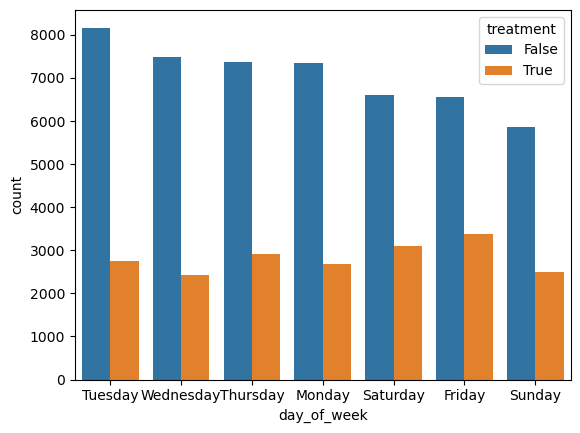

In [13]:
sns.barplot(day_week, x='day_of_week', y='count', hue='treatment')

In [14]:
hour = df.groupby('treatment')['hour'].value_counts().reset_index()

<Axes: xlabel='hour', ylabel='count'>

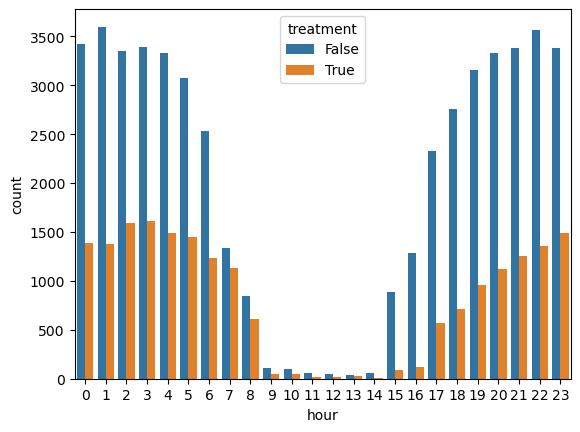

In [15]:
sns.barplot(hour, x='hour', y='count', hue='treatment')

The start_time of the messages is lower between 9-14 hr. However there is no visual evidence suggesting a bias in the assignment of the treatment.


#### Conclusion of SRM Analysis:
The issignment of the treatment started in November. 

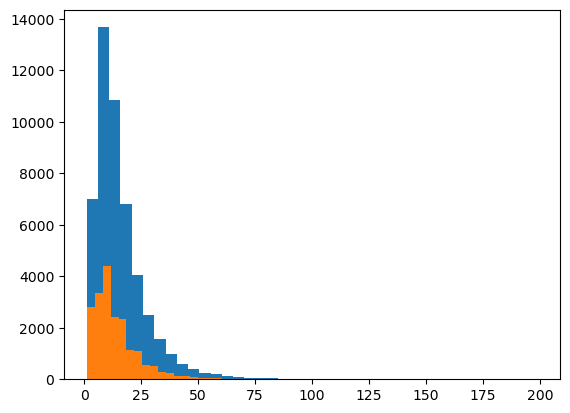

In [16]:
plt.hist(df[df['treatment']==False]['rep_sent_msgs'], bins = 40)
plt.hist(df[df['treatment']==True]['rep_sent_msgs'], bins = 40)
plt.show()

In [35]:
df_nov = df[df['month'] == 11].copy()
df_nov.head()

,start_time,rep_id,rep_sent_msgs,augmented_msgs,treatment,day_of_week,month,hour,failures
5611,2018-11-01 01:19:30,1130001,33,3,False,Thursday,11,1,30
5612,2018-11-01 01:16:44,3370001,18,4,False,Thursday,11,1,14
5613,2018-11-01 01:06:47,1130001,17,1,False,Thursday,11,1,16
5614,2018-11-01 01:18:07,1540001,17,1,False,Thursday,11,1,16
5615,2018-11-01 01:26:04,3320001,9,7,False,Thursday,11,1,2


In [71]:
df_nov.groupby('treatment')['treatment'].value_counts()

treatment
False    26452
True     19743
Name: count, dtype: int64

In [78]:
false_prop = df_nov[df_nov['treatment'] == False]['treatment'].count() / len(df_nov)
true_prop = df_nov[df_nov['treatment'] == True]['treatment'].count() / len(df_nov)

print(round(false_prop,2))
print(round(true_prop,2))

0.57
0.43


In [39]:
len(df_nov)

46195

# 2) Data Modeling:

We will model the data as a Binomial Regression. This means to evaluate if the amount of `augmented_messages` as binomial success over the `rep_sent_msgs`. We model the probability of success of the binomial experiment as a means of treatment, `hour` and `rep_sent_msgs`. 


`augmented_messages` ~ *Binomial*(*n*=rep_sent_msgs, *p*) 

**The model estimates:**

ln(*p*/(1-*p*)) = ln(odds) = B0 + B1.Treatment + B2.hour + B3.rep_sent_msgs

Where odds is the ratio between the probability of the message of being augmented respect to the probability of being not augmented.

In [22]:
df_nov["failures"] = df_nov["rep_sent_msgs"] - df_nov["augmented_msgs"]

In [26]:
model = smf.glm("augmented_msgs + failures ~ treatment + hour + rep_sent_msgs", 
                data=df_nov, 
                family=sm.families.Binomial())

result = model.fit(cov_type="HC3")  

In [48]:
# calculat the overdispersion index. 

round(result.pearson_chi2 / result.df_resid,2)

# sum of pearson residuals / residuals LG.

3.49

This shows there is overdispersion. This meands there is more variablity than expected by the mdel. reason why correcting standard errors is important. The correction does not correct the overdispersion but adjusts the SE for a robust inference.

In [28]:
print(result.summary())

                       Generalized Linear Model Regression Results                        
Dep. Variable:     ['augmented_msgs', 'failures']   No. Observations:                46195
Model:                                        GLM   Df Residuals:                    46191
Model Family:                            Binomial   Df Model:                            3
Link Function:                              Logit   Scale:                          1.0000
Method:                                      IRLS   Log-Likelihood:            -1.4617e+05
Date:                            Wed, 30 Jul 2025   Deviance:                   1.8579e+05
Time:                                    12:27:39   Pearson chi2:                 1.61e+05
No. Iterations:                                 4   Pseudo R-squ. (CS):           0.001524
Covariance Type:                              HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----

B1 (i.e. effect of tratment): `-0.0173`. This is the `ln(Odds Ratio)`, `Odds Ratio = odds_treatment / odds_control`. As the confidence interval includes 0, `OR ~ 0`. This means the chance of a message being augmented in the treatment is not statistically different respect to control.

**There is no statisticaly significant effect of the tratment** over the number of augmented responses. The inference is valid do to standard error correction.   

## Model Supposals:

### 3.1) Independence:

There is some lack of independence within observations, as the number of augmented messages comes from the same conversation, introducing  overdispersion. However, we addressed this by using HC3 robust standard errors, which improves the reliability of the statistical inference.

### 3.2) Pattern in residuals:

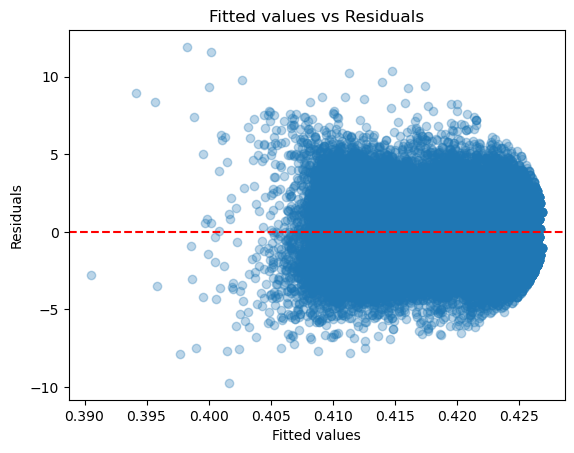

In [30]:
fitted = result.fittedvalues
resid = result.resid_deviance

plt.scatter(fitted, resid, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Fitted values vs Residuals")
plt.show()

No evidence of symetric patterns

# 3) Report:

## Overview: 

We conducted an A/B experiment to determine if the changes in the new model increased the proportion of augmented messages sent by the agent. This report summarizes the findings based on a statistical model applied to the results of 46,195 conversations.

## Experimental Design:
The original dataset was imbalanced across conditions. To reduce this, we selected only data from November, the period when both treatment and control were concurrently active, resulting in a less imbalanced sample (43% treatment, 57% control). We also included other relevant variables and adjusted the standard error. For future experiments, we recommend a balanced randomized treatment assignment to avoid potential bias.

## Model and Assumptions:
We used a binomial generalized linear model (GLM) with robust standard error to:
1. model the number of augmented messages sent out of the total messages sent per conversation.
2. account for variability in conversation length and time of day.


The inclsion of these variables and the correction of standard errors helps mitigate the bias caused by intra-conversation correlation. These helps correct the significance to do inference.

## Key Results:
- B1 (i.e. tratment coefficient): `-0.0173`. This is the `ln(Odds Ratio)`, `Odds Ratio = odds_treatment / odds_control`. As the confidence interval includes 0, `OR ~ 0`. This means the chance of a message being augmented in the treatment is not statistically different respect to control.The inference is valid do to standard error correction. 
- p-value: < 0.05. **There is no statisticaly significant effect of the tratment** over the number of augmented responses.

## Interpretation:
- No statistically significant impact of the new model on augmentation rate was found.